# Regression

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.formula.api as sm
import statsmodels.api as sma
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split

from tools import *

In [76]:
db = pd.read_csv("data/player_stats_extended.csv")
db = db_to_numeric(db)

db.head()

,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,AVG_DRIB_PER_TOUCH,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM,INJURED ON,RETURNED,DAYS MISSED,INJURED_TYPE,INJURY_SEVERITY
0,1630639,A.J. Lawson,22-23,22.5,22.0,78.0,179.0,13,4.8,0.182,...,0.62,0.0,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN
1,1631260,AJ Green,22-23,22.5,23.0,77.0,190.0,32,9.4,0.160,...,1.84,0.1,0.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN
2,1631100,AJ Griffin,22-23,22.5,19.0,78.0,220.0,66,19.4,0.174,...,1.49,0.4,0.0,0.7,NaN,NaN,NaN,NaN,NaN,NaN
3,203932,Aaron Gordon,22-23,22.5,27.0,80.0,235.0,61,30.1,0.206,...,2.11,1.8,2.1,6.8,Nuggets,NaN,2023-02-07,5.0,Sprained_ankle,Moderate
4,1628988,Aaron Holiday,22-23,22.5,26.0,72.0,185.0,57,13.7,0.128,...,3.82,0.1,0.0,0.4,NaN,NaN,NaN,NaN,NaN,NaN


## Number of injuries and age

### Scatter plots

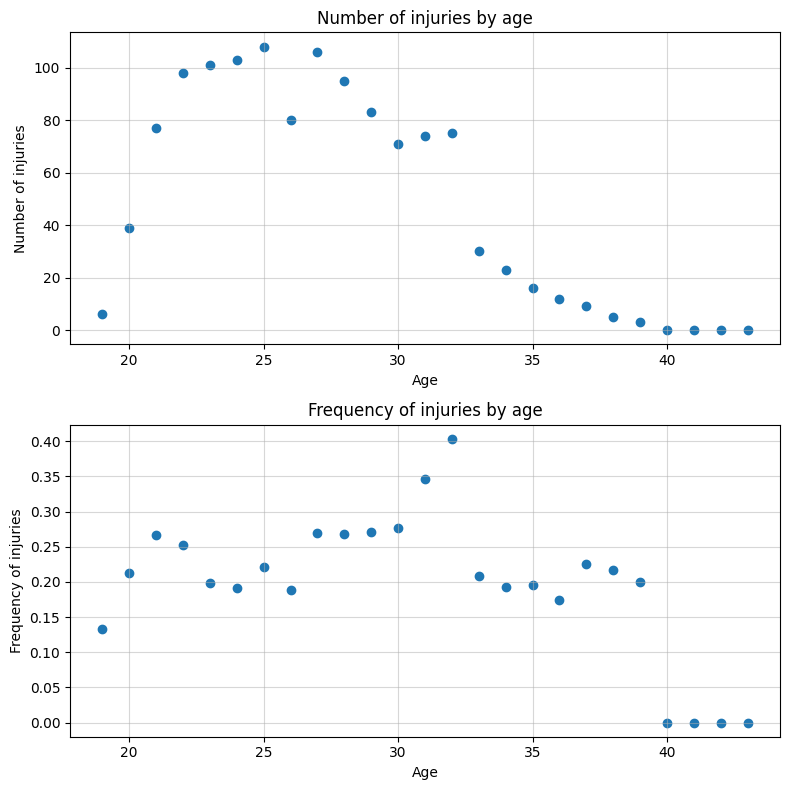

In [77]:
# db that contains the number of injuries for each age
injuries_age = pd.DataFrame([
    {
    'Age': int(a), 
    'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())]),
    'unique_players': len(db[db["AGE"] == a]["PLAYER_ID"].unique())
    }
    for a in sorted(db["AGE"].unique())
])

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].scatter(injuries_age["Age"], injuries_age["injuries_number"])
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Number of injuries")
ax[0].set_title("Number of injuries by age")
ax[0].grid(alpha=0.5)

ax[1].scatter(injuries_age["Age"], injuries_age["injuries_number"] / injuries_age["unique_players"])
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Frequency of injuries")
ax[1].set_title("Frequency of injuries by age")
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

This already doesn't look especially promising: the trend that the first graph (Number of injuries by age) shows is most probably influenced by the different age distribution in the dataset (as in the graph below).

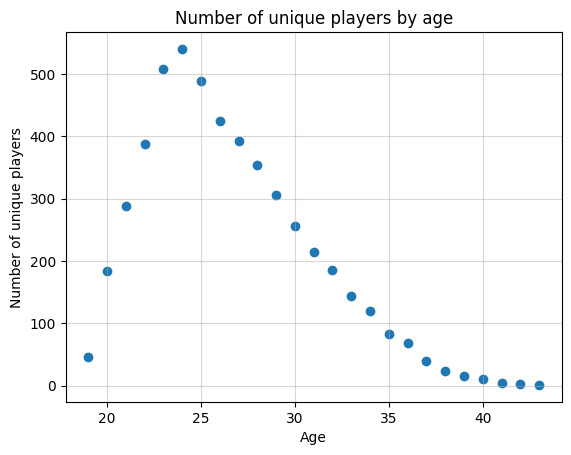

In [78]:
plt.scatter(injuries_age["Age"], injuries_age["unique_players"])
plt.xlabel("Age")
plt.ylabel("Number of unique players")
plt.title("Number of unique players by age")
plt.grid(alpha=0.5)
plt.show()

### Linear regression

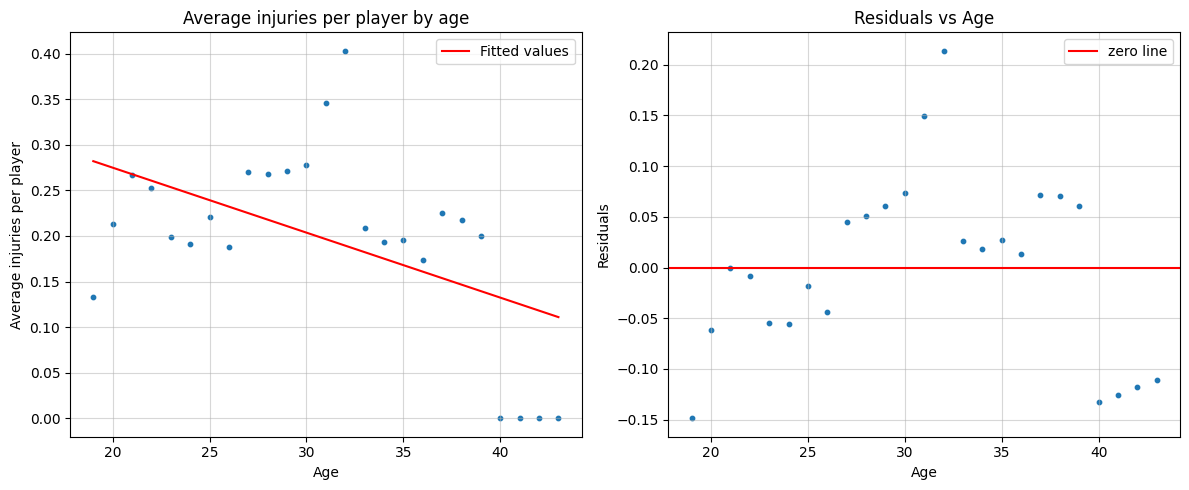

In [79]:
injuries_age_stats = pd.DataFrame({
    'Age': injuries_age['Age'],
    'injuries_ratio': injuries_age['injuries_number']/injuries_age['unique_players']
})

res = sm.ols('injuries_ratio ~ Age', data=injuries_age_stats).fit()
residuals = res.resid

summary = plot_linear_regression(injuries_age_stats, res, residuals)

In [80]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:         injuries_ratio   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     7.946
Date:                 Fr, 16 Mai 2025   Prob (F-statistic):            0.00974
Time:                        13:09:55   Log-Likelihood:                 25.447
No. Observations:                  25   AIC:                            -46.89
Df Residuals:                      23   BIC:                            -44.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4175      0.080      5.188      0.0

### Age recovery time

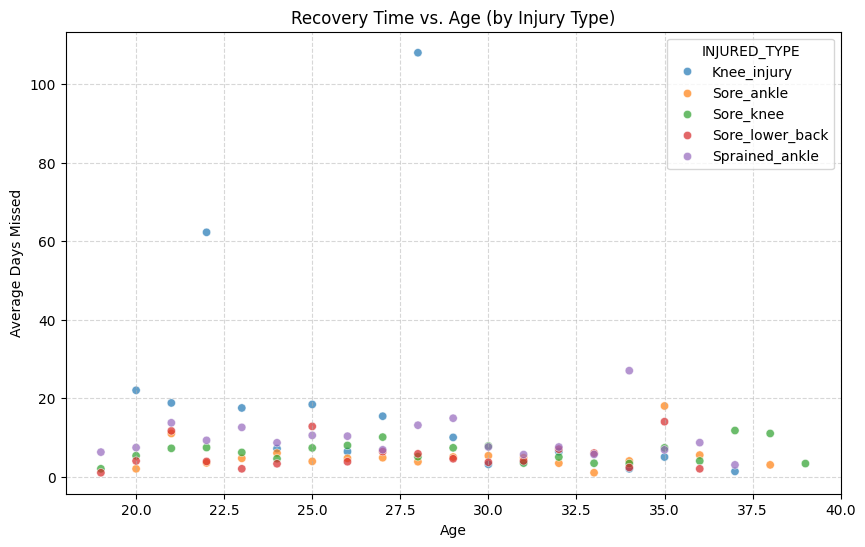

In [81]:
age_recoverytime = db[["AGE", "DAYS MISSED", "INJURED_TYPE"]].copy()
recovery_by_age_and_type = age_recoverytime.groupby(['INJURED_TYPE', 'AGE'])['DAYS MISSED'].mean().reset_index()

age_recoverytime.head()

plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(
    data=recovery_by_age_and_type,
    x='AGE',
    y='DAYS MISSED',
    hue='INJURED_TYPE',
    alpha=0.7  # Adjust transparency for better readability
)

# Add title and labels
plt.title("Recovery Time vs. Age (by Injury Type)")
plt.xlabel("Age")
plt.ylabel("Average Days Missed")

# Show grid for better visualization
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()

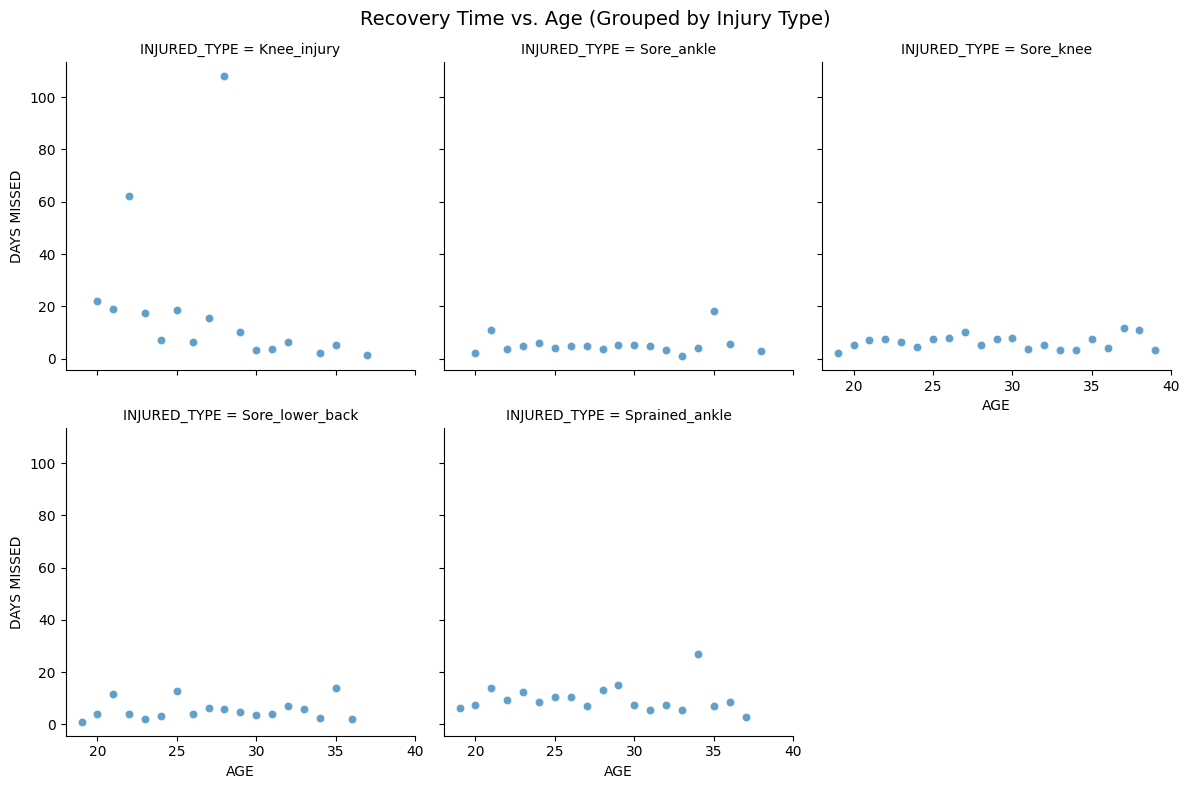

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the FacetGrid with each injury type as a separate plot
g = sns.FacetGrid(recovery_by_age_and_type, col="INJURED_TYPE", col_wrap=3, height=4, sharex=True, sharey=True)

# Map scatter plots onto each subplot
g.map_dataframe(sns.scatterplot, x="AGE", y="DAYS MISSED", alpha=0.7)

# Add title to the overall figure
g.fig.suptitle("Recovery Time vs. Age (Grouped by Injury Type)", fontsize=14)

# Adjust layout
g.tight_layout()

# Show the plots
plt.show()

## Mutliple linear regression

### Multiple regression on total number of injuries

We aim to find the attributes that best predicts number of injuries among players

In [83]:
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna())]),
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[db["PLAYER_ID"] == p]["GP"].sum(),
        'minutes': db[db["PLAYER_ID"] == p]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)

res_train = sm.ols('injuries_number ~ age + games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ age + games_played + minutes', data=test_data).fit()

Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     445.3
Date:                 Fr, 16 Mai 2025   Prob (F-statistic):          9.57e-190
Time:                        13:09:57   Log-Likelihood:                -1940.3
No. Observations:                1112   AIC:                             3889.
Df Residuals:                    1108   BIC:                             3909.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1198      0.283

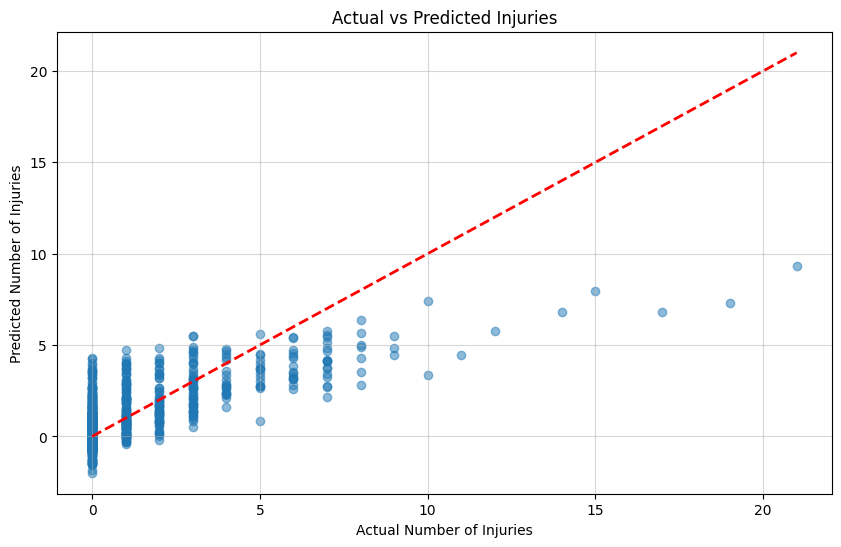

partial regression plot (training set):


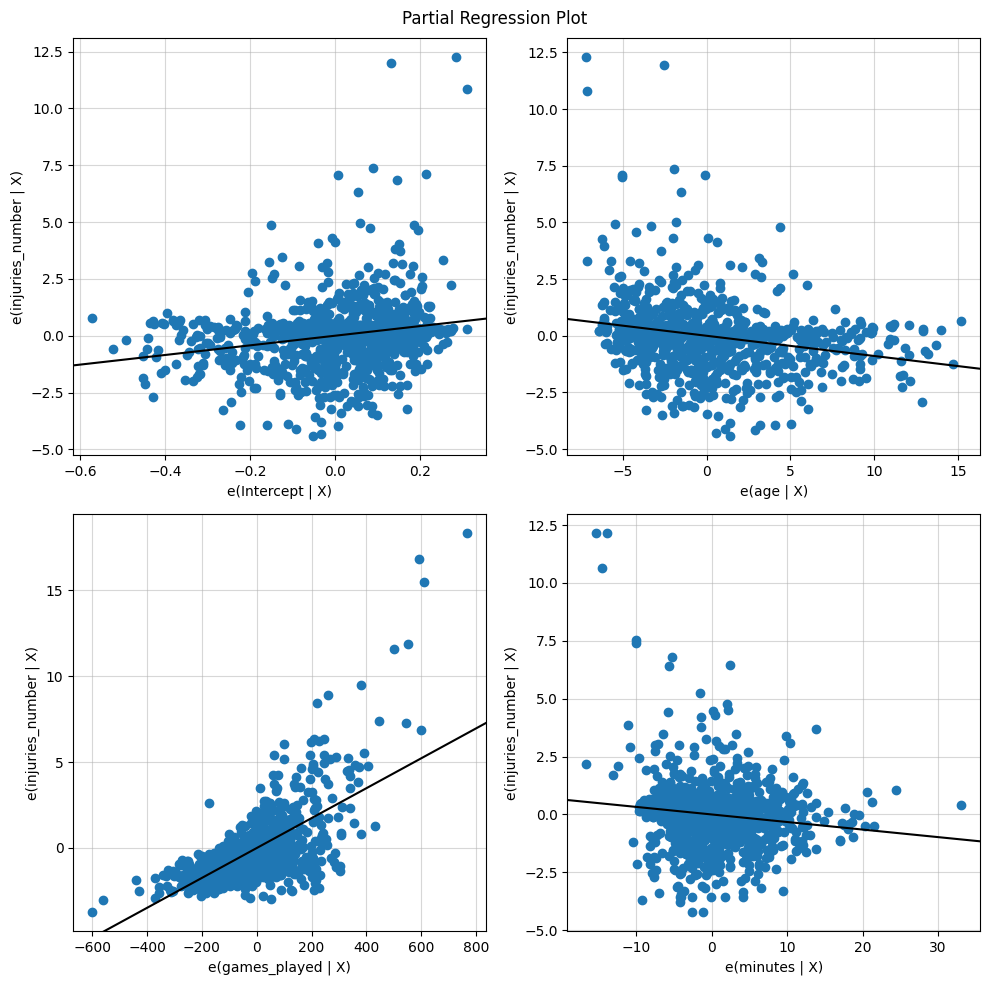

multiple regression plot (test set):


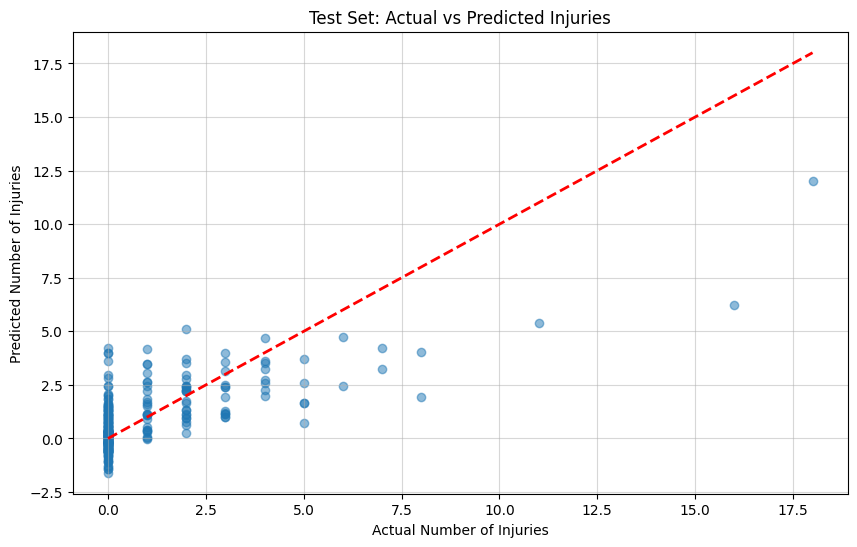

partial regression plot (test set):


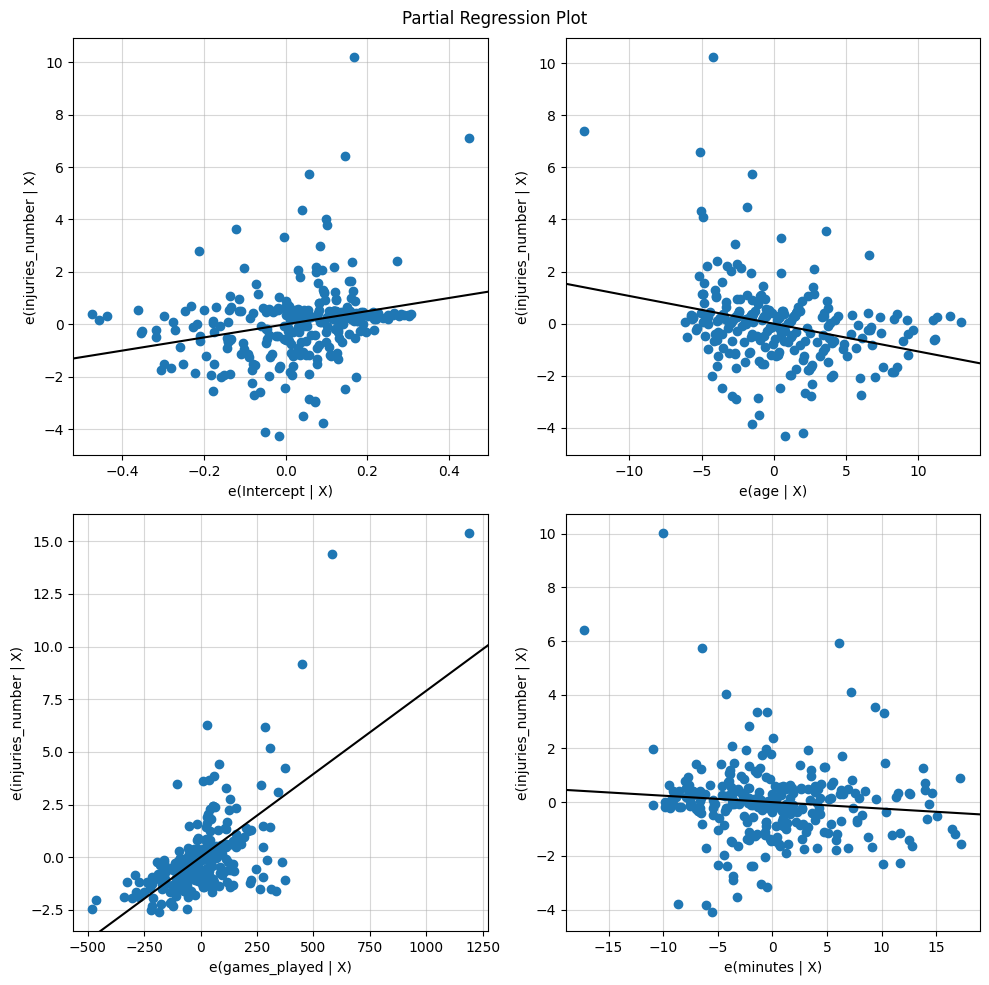

In [84]:
multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

### Multiple regression on number of injuries by season

In [85]:
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["SEASON_NUM"] == s) & (db["INJURED_TYPE"].notna())]),
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[(db["PLAYER_ID"] == p) & (db["SEASON_NUM"] == s)]["GP"].sum(),
        'minutes': db[(db["PLAYER_ID"] == p) & (db["SEASON_NUM"] == s)]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
    for s in db[db["PLAYER_ID"] == p]["SEASON_NUM"].unique()
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)

res_train = sm.ols('injuries_number ~ age + games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ age + games_played + minutes', data=test_data).fit()

Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     859.4
Date:                 Fr, 16 Mai 2025   Prob (F-statistic):               0.00
Time:                        13:10:06   Log-Likelihood:                -2984.6
No. Observations:                4160   AIC:                             5977.
Df Residuals:                    4156   BIC:                             6003.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2263      0.050

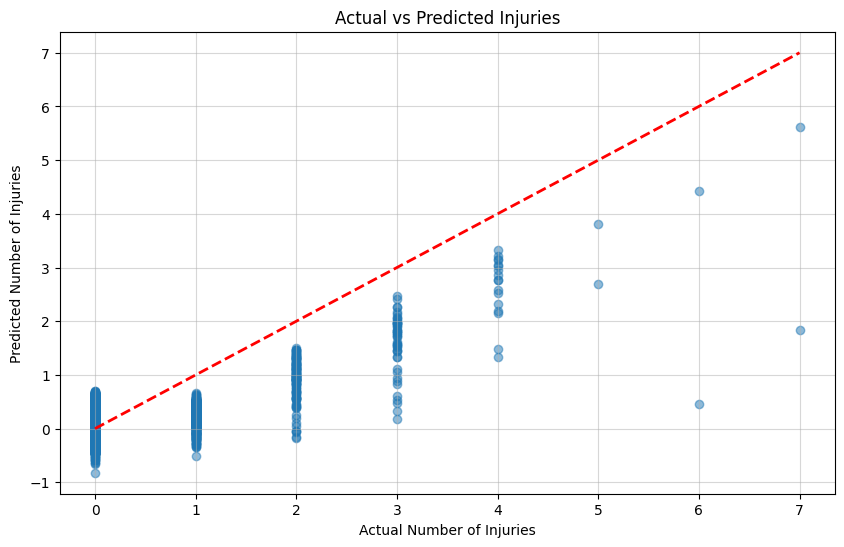

partial regression plot (training set):


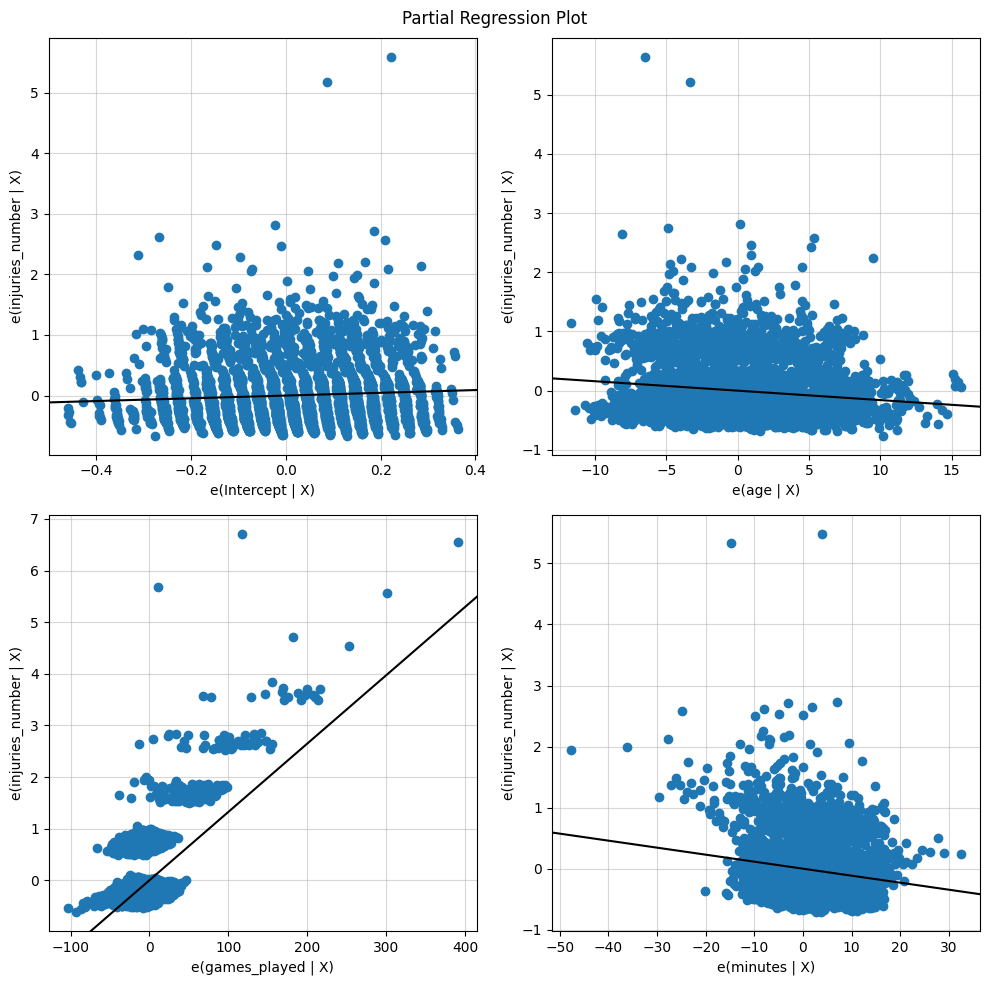

multiple regression plot (test set):


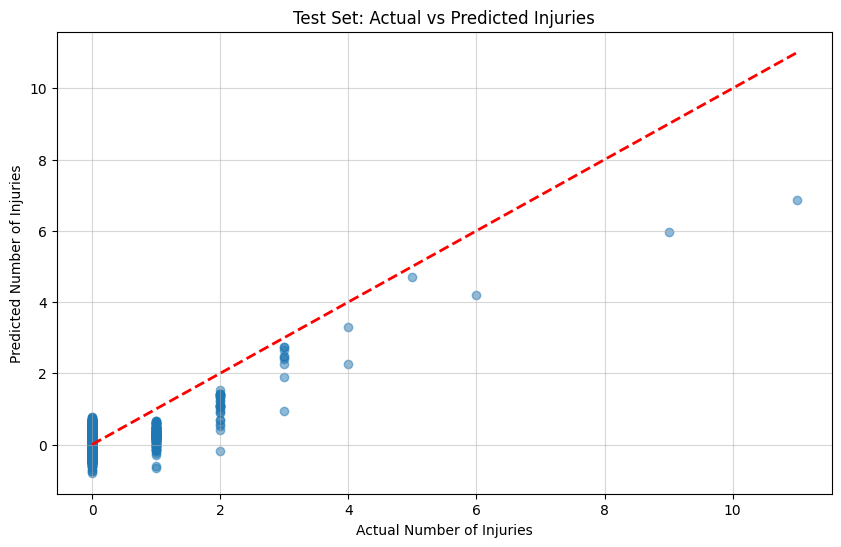

partial regression plot (test set):


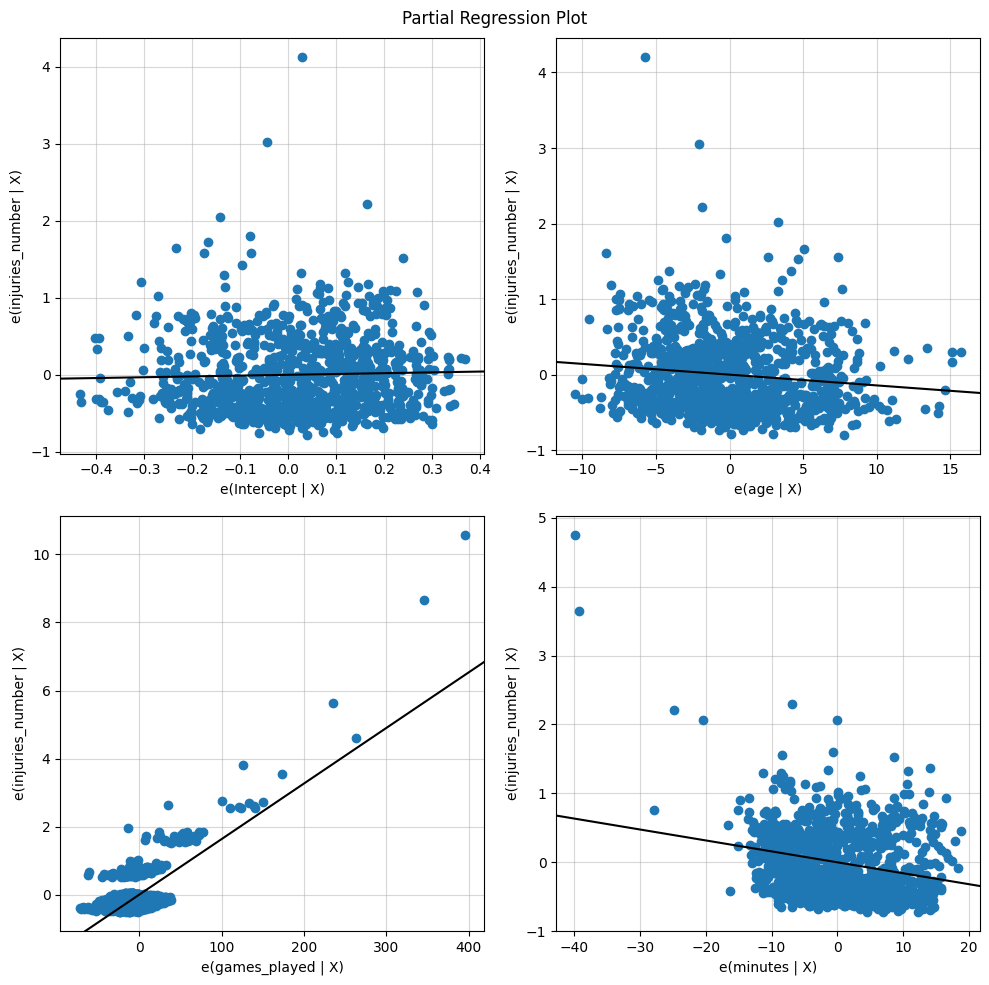

In [86]:
multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

### Multiple regression on number of injuries by injury type

In [87]:
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"] == i)]),
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[(db["PLAYER_ID"] == p)]["GP"].sum(),
        'minutes': db[(db["PLAYER_ID"] == p)]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
    for i in db[db["PLAYER_ID"] == p]["INJURED_TYPE"].unique()
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)

res_train = sm.ols('injuries_number ~ age + games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ age + games_played + minutes', data=test_data).fit()

Training Set:
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     211.4
Date:                 Fr, 16 Mai 2025   Prob (F-statistic):          9.20e-116
Time:                        13:10:15   Log-Likelihood:                -2284.7
No. Observations:                1627   AIC:                             4577.
Df Residuals:                    1623   BIC:                             4599.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9949      0.180

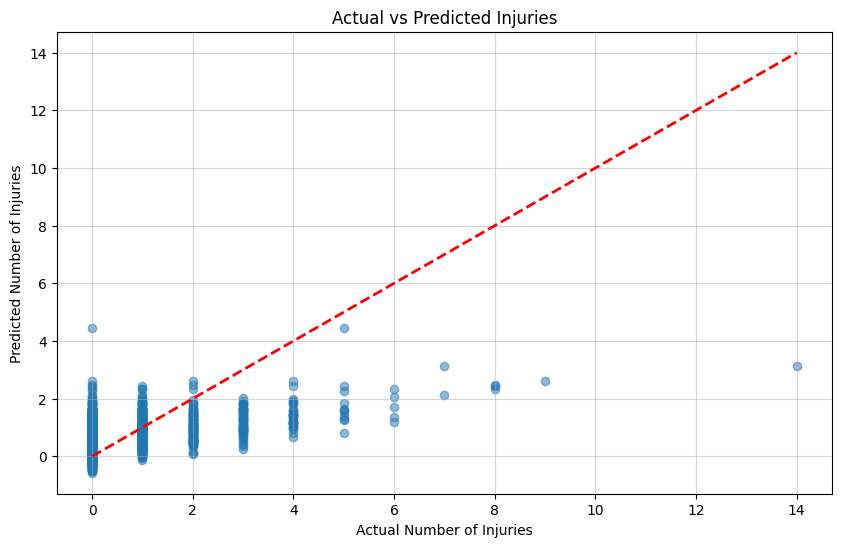

partial regression plot (training set):


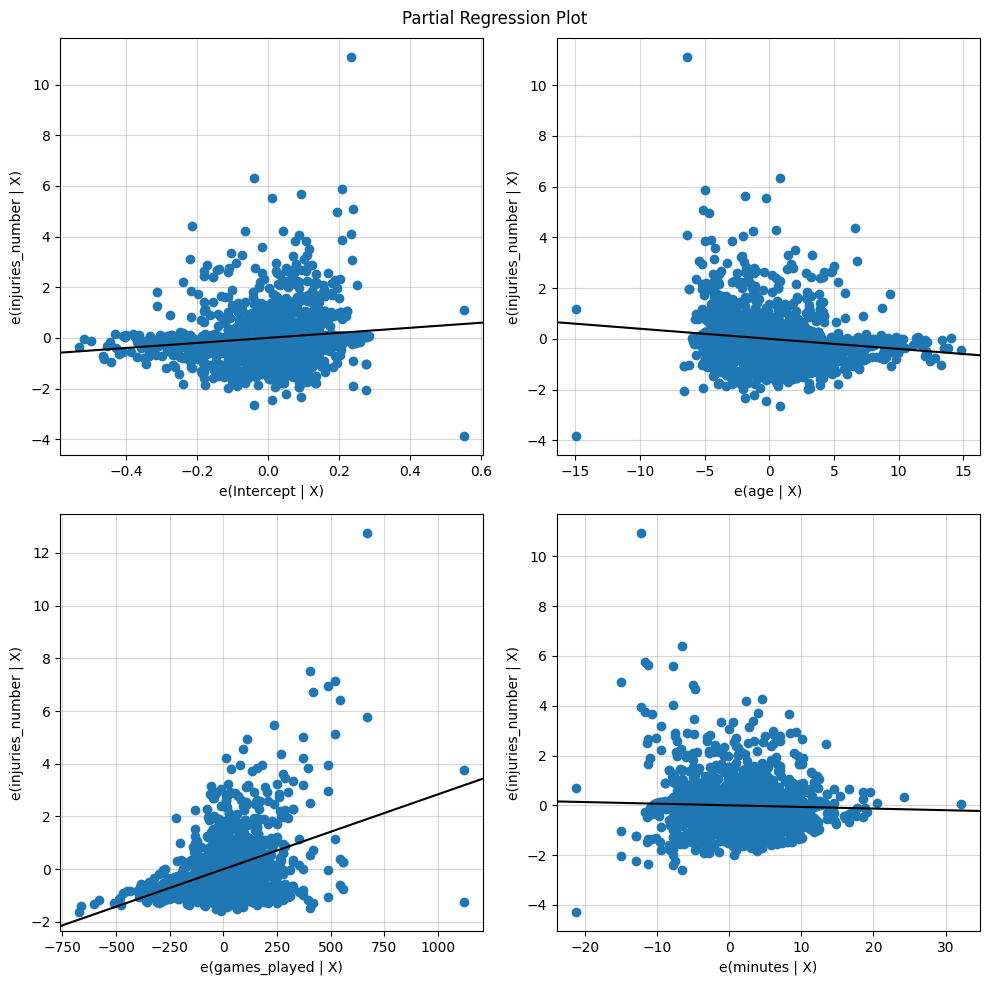

multiple regression plot (test set):


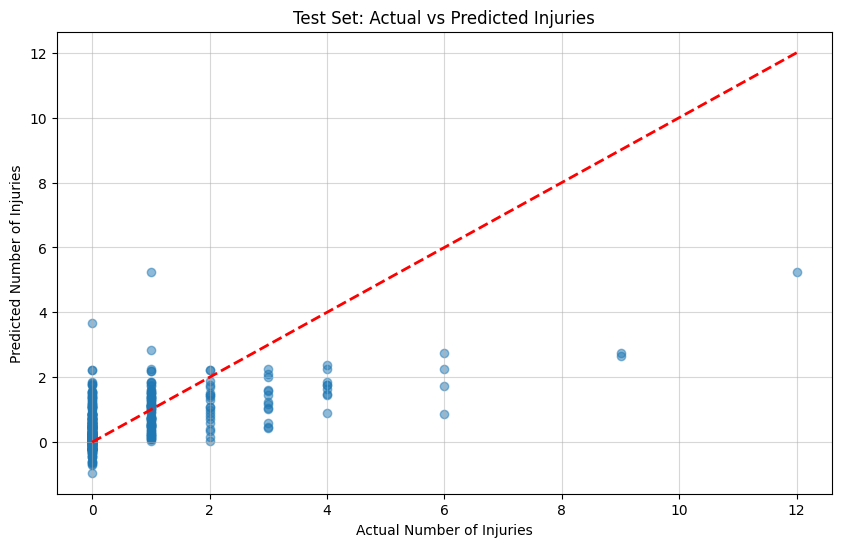

partial regression plot (test set):


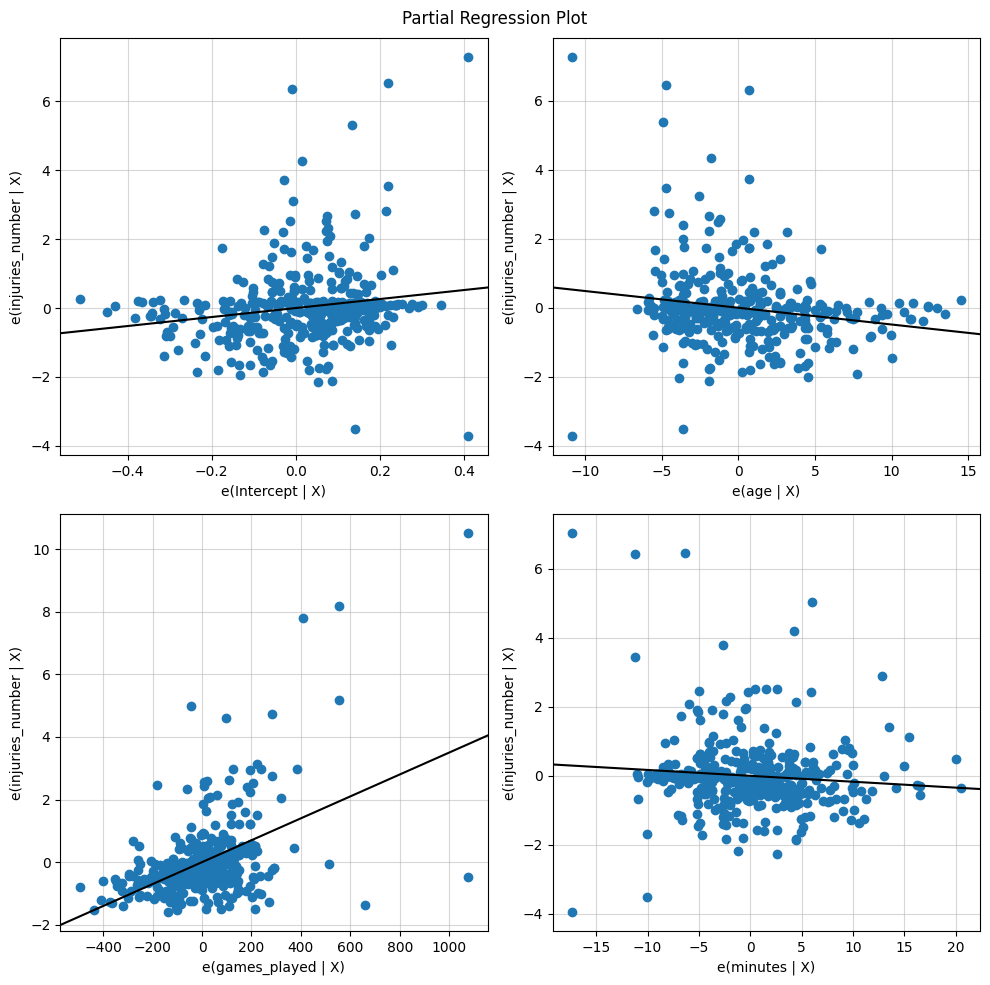

In [88]:
multiple_regression_result(
    res_train, res_test, injuries_multiple, test_data, train_data
)

## Multiple logistic regression

In [89]:
injuries_multiple_outcome = pd.DataFrame([
    {
        'has_injuries': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna())]) > 0,
        'age': db[db["PLAYER_ID"] == p]["AGE"].iloc[0],
        'games_played': db[db["PLAYER_ID"] == p]["GP"].sum(),
        'minutes': db[db["PLAYER_ID"] == p]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
])

print("Class distribution:")
print(injuries_multiple_outcome['has_injuries'].value_counts())

Class distribution:
has_injuries
False    994
True     397
Name: count, dtype: int64


In [90]:
# Split data into train and test sets
train_data, test_data = train_test_split(injuries_multiple_outcome, test_size=0.2, random_state=42, stratify=injuries_multiple_outcome['has_injuries'])

# Prepare features and target for training
X_train = train_data[['games_played', 'minutes']]
y_train = train_data['has_injuries']

# Prepare features and target for testing 
X_test = test_data[['games_played', 'minutes']]
y_test = test_data['has_injuries']

# Fit logistic regression model
lm = linear_model.LogisticRegression(solver='lbfgs')
lm.fit(X_train, y_train)

# Make predictions on both train and test sets
train_probabilities = lm.predict_proba(X_train)
train_pred = lm.predict(X_train)
test_probabilities = lm.predict_proba(X_test)
test_pred = lm.predict(X_test)

# Add predictions to dataframes
train_data['predicted_prob'] = train_probabilities[:, 1]
train_data['predicted'] = train_pred
test_data['predicted_prob'] = test_probabilities[:, 1]
test_data['predicted'] = test_pred

# Calculate accuracy score on test data
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Training accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

train_data.head()

Training accuracy: 0.8147
Test accuracy: 0.8208


,has_injuries,age,games_played,minutes,predicted_prob,predicted
1094,False,33.0,215,20.000000,0.296949,False
864,False,23.0,8,12.300000,0.075812,False
342,False,22.0,44,13.500000,0.097807,False
321,True,25.0,221,15.600000,0.265123,False
631,False,35.0,629,25.155556,0.876657,True


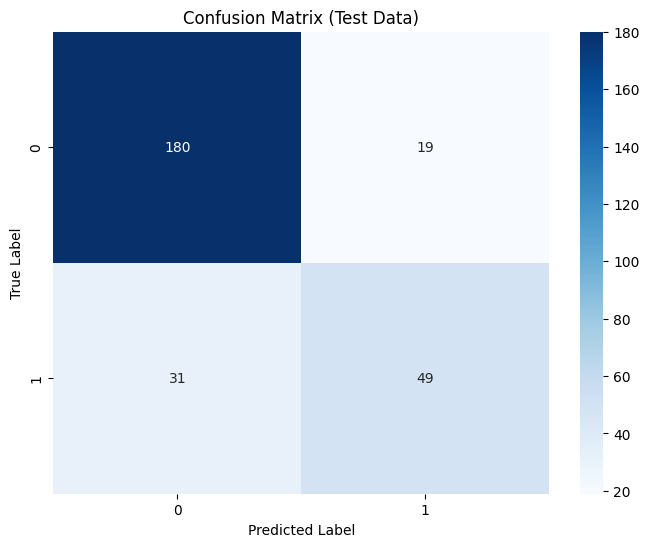

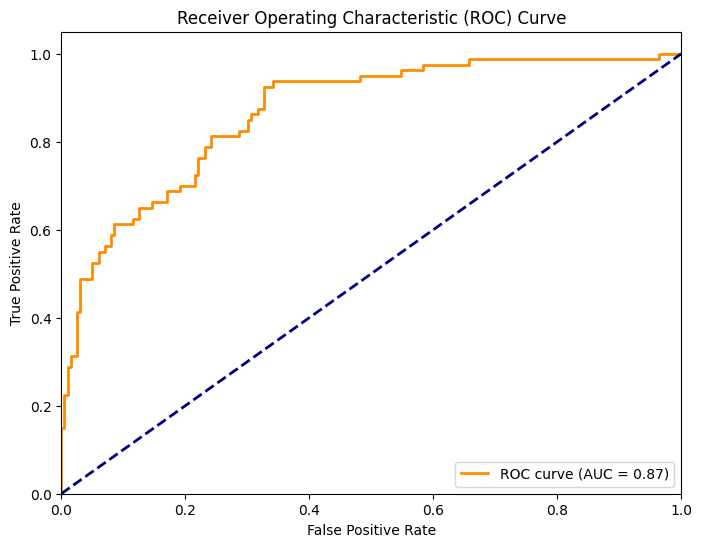

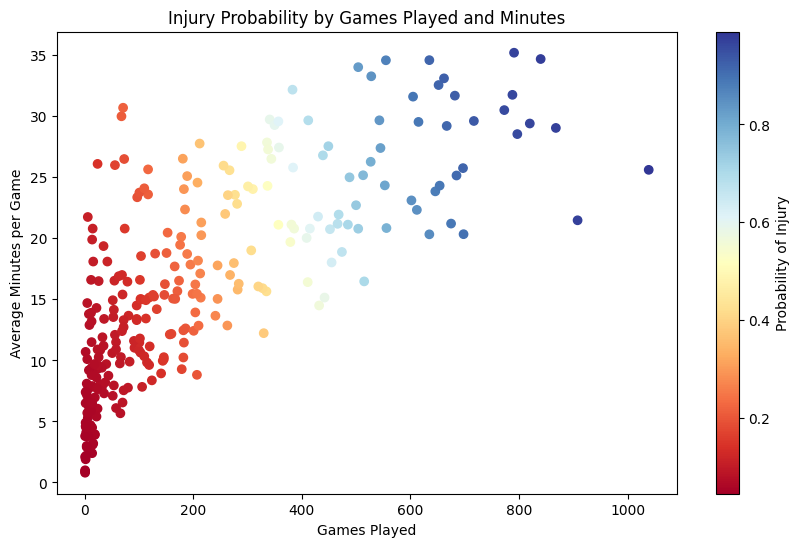


Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.90      0.88       199
        True       0.72      0.61      0.66        80

    accuracy                           0.82       279
   macro avg       0.79      0.76      0.77       279
weighted avg       0.82      0.82      0.82       279



In [91]:
# Create confusion matrix for test data
cm = confusion_matrix(y_test, test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Create scatter plot of features with prediction probabilities
plt.figure(figsize=(10, 6))
scatter = plt.scatter(test_data['games_played'], test_data['minutes'], 
                     c=test_probabilities[:, 1], cmap='RdYlBu')
plt.colorbar(scatter, label='Probability of Injury')
plt.xlabel('Games Played')
plt.ylabel('Average Minutes per Game')
plt.title('Injury Probability by Games Played and Minutes')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, test_pred))


Multiple Regression: Does a previous injury increase the likelihood of future injuries in NBA players? 

In [95]:
# amount of injuries per player
injury_counts = db.groupby("PLAYER_ID")["INJURED_TYPE"].count().reset_index()
injury_counts.rename(columns={"INJURED_TYPE": "total_injuries"}, inplace=True)

no_injury = (injury_counts["total_injuries"] == 0).sum()
one_injury = (injury_counts["total_injuries"] == 1).sum()
multiple_injuries = (injury_counts["total_injuries"] > 1).sum()

print(f"Players without injury: {no_injury}")
print(f"Players with one injury: {one_injury}")
print(f"Players with multiple injuries: {multiple_injuries}")

one_injury = injury_counts[injury_counts["total_injuries"] == 1].shape[0]
multiple_injuries = injury_counts[injury_counts["total_injuries"] > 1].shape[0]

# calculate the reinjury rate
reinjury_rate = multiple_injuries / (one_injury + multiple_injuries)
print(f"reinjury rate: {reinjury_rate:.2f}")



Players without injury: 994
Players with one injury: 147
Players with multiple injuries: 250
reinjury rate: 0.63
